# Bank Customer Churn Prediction
## EDA

In [273]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot') #'fivethirtyeight')
import seaborn as sns

import numpy as np
import pandas as pd

import scipy.stats as scs
import scipy

import itertools
from collections import Counter

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



In [179]:
# read in the data
df = pd.read_csv('../data/bank_churn.csv', ';')

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [181]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [182]:
df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [183]:
# We can drop the 'customer_id', as it carries no signal
df = df.drop(['customer_id'], axis=1)

In [184]:
# Describe
df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


The data is clean!

Countries:  ['France' 'Spain' 'Germany']


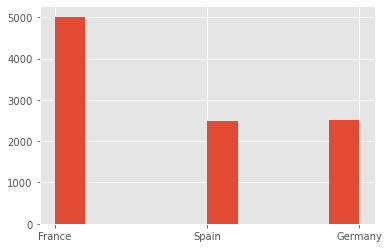

In [185]:
# Countries - see if it is imbalanced
print('Countries: ', df['country'].unique())
df['country'].hist();

The data is Spain and Germany are each a quarter of the entire data with France having the other half. This should not be a problem.

Genders:  ['Female' 'Male']


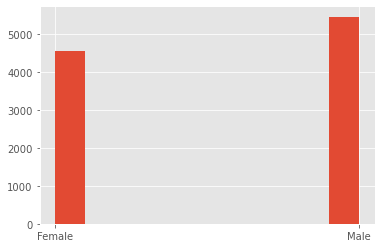

In [186]:
# Genders - check if it is imbalanced
print('Genders: ', df['gender'].unique())
df['gender'].hist();

Evenly balanced male vs. female data

In [187]:
# We can change 'gender' to 0 for female and 1 for male
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

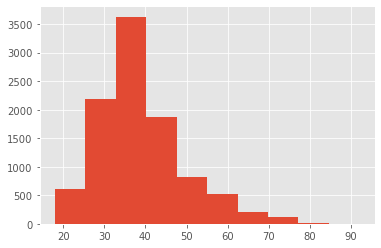

In [188]:
# Ages - check distribution
df['age'].hist();

Normally distributed age data with slight right skew

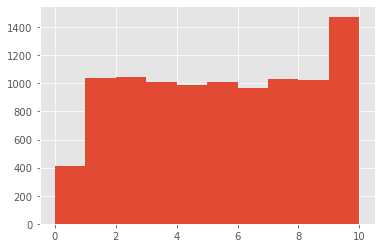

In [189]:
# Tenures - check distribution
df['tenure'].hist();

Uniform distribution of tenure data from 1 to 9 years. Under-represented new customers, over-represented 10-year customers.

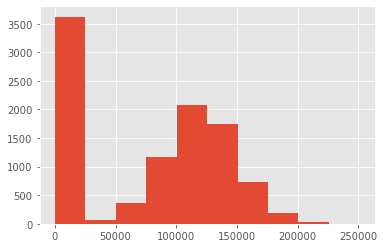

In [190]:
# Balance - check distribution
df['balance'].hist();

Normally distributed, except for the anomaly at the lower end (zero balance) - are these new customers?

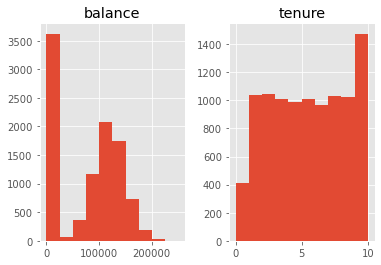

In [191]:
df[['balance', 'tenure']].hist();

There does not appear to be a relationship between very low balance and tenure. 

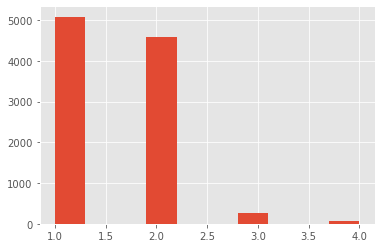

In [192]:
# Number of products used - check distribution
df['products_number'].hist();

About the same # of customers having 1 and 2 products, very few with 3 or 4 products.

Credit cards:  [1 0]


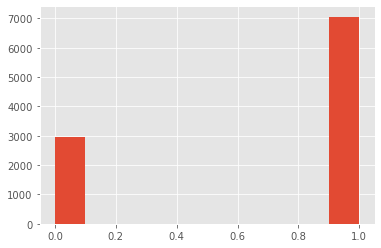

In [193]:
# Credit Card - confirm that is categorical (and NOT a count of credit cards a customer holds), check distribution
print('Credit cards: ', df['credit_card'].unique())
df['credit_card'].hist();

Slightly less than half the customers do not have credit cards. Should not be a problem.

Active Member:  [1 0]


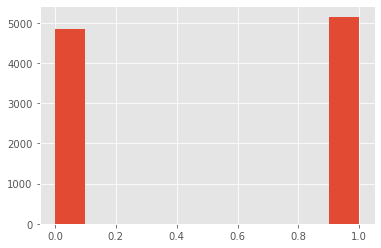

In [194]:
# Active Member - confirm that this is categorical, check distribution
print('Active Member: ', df['active_member'].unique())
df['active_member'].hist();

df['active'] is a categorical feature and is evenly distributed between active and non-active members

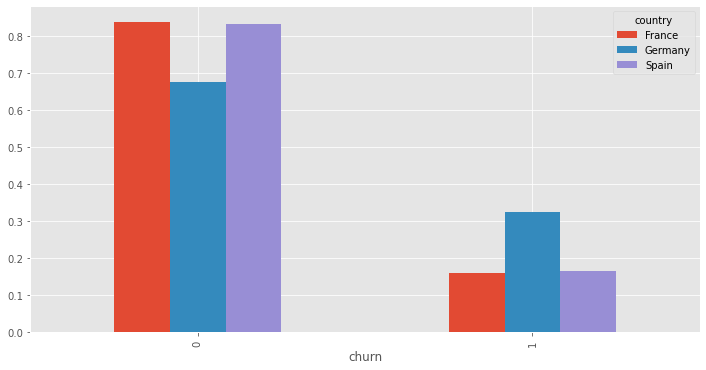

In [195]:
# Percent of customers who churned from each country
churned = pd.crosstab(df['churn'], df['country'], rownames=['churn'])
(churned / churned.apply(sum)).plot(kind="bar", figsize=(12, 6));

In [196]:
# Is the distribution of churn unbalanced?
df['churn'].value_counts() / len(df)

0    0.7963
1    0.2037
Name: churn, dtype: float64

Churn is about the same in France and Spain, but more in Germany. 

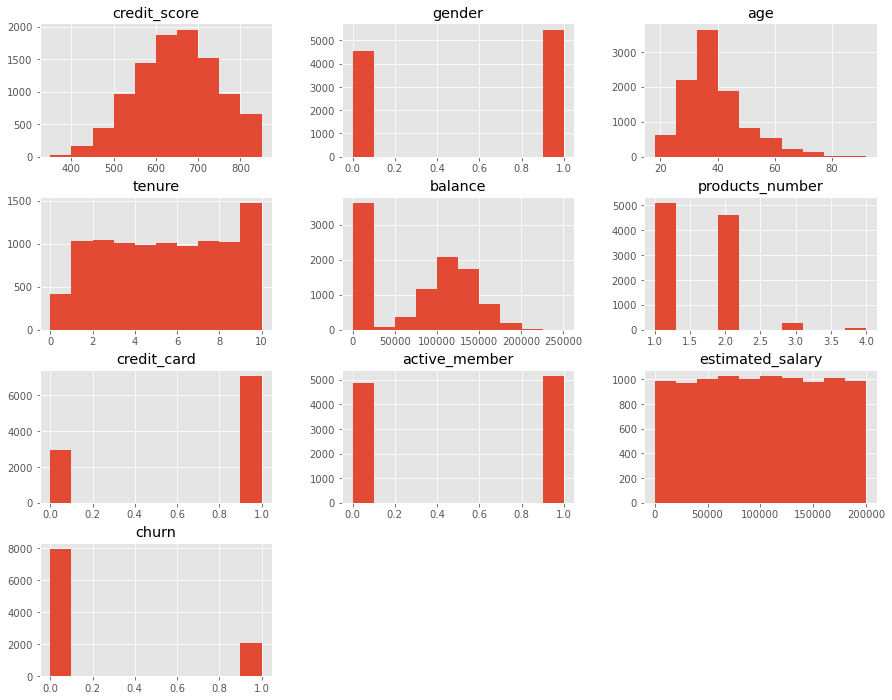

In [197]:
# Sanity check
df.hist(figsize=(15, 12));

All distributions are not too unbalanced and so should be OK


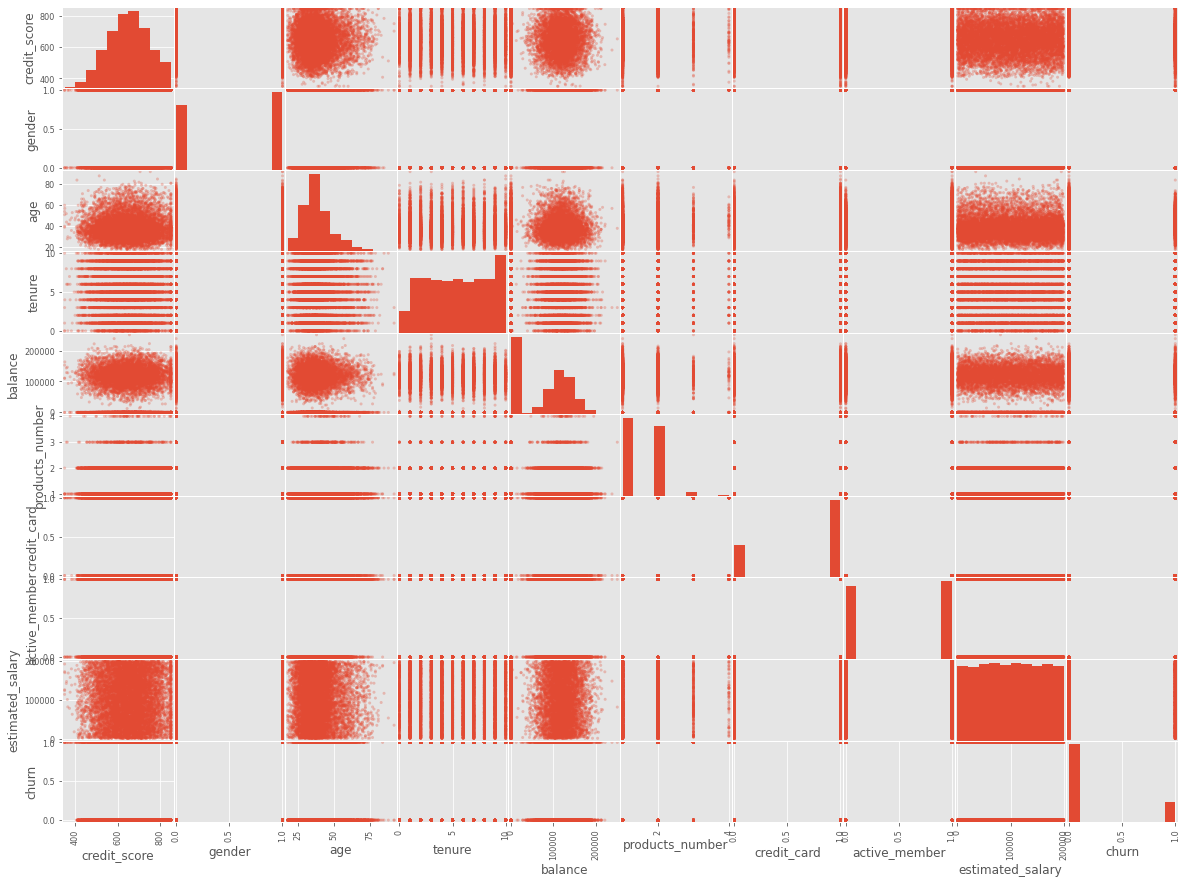

In [198]:
# Plot a scatter matrix of all features
pd.plotting.scatter_matrix(df, figsize=(20, 15), alpha=0.3);

There does not appear to be any obvious correlations between any single feature and churn

Let's look again at overall churn and churn by 'country' feature, we know that Germany has the worst churn

In [199]:
# 1 = Churn, 0 = Not Churn
print('Overall Churn = ', df['churn'].mean())

Overall Churn =  0.2037


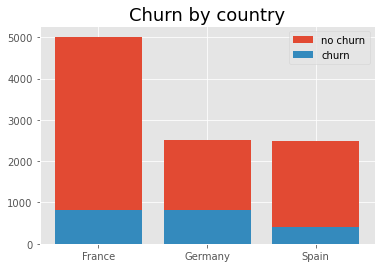

In [200]:
churn_by_country = df.groupby('country')['churn'].count()
num_churn_by_country = df.groupby('country')['churn'].sum()
plt.bar(churn_by_country.index, churn_by_country.values, label='no churn')
plt.bar(num_churn_by_country.index, num_churn_by_country.values, label='churn')
plt.title('Churn by country', fontsize=18)
plt.legend();

#### Explore some intuitive questions

Do customers that churn have lower credit scores?

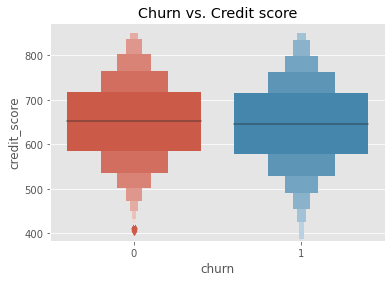

In [201]:
sns.boxenplot(df['churn'], df['credit_score'])
plt.title('Churn vs. Credit score')
plt.savefig('../Images/Churn_vs_CreditScore.png')

Apparently not. Customers that churn have the same credit score distribution as those that don't churn.

Do customers with a lower balance churn more?

In [202]:
# dummies = pd.get_dummies(df['country'], prefix='country')
# X2 = df[['gre','gpa']].join(dummies.loc[:,'rank_2':]).values
# X2

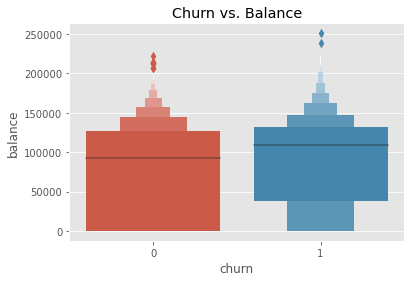

In [203]:
sns.boxenplot(df['churn'], df['balance'])
plt.title('Churn vs. Balance')
plt.savefig('../Images/Churn_vs_Balance.png')

Again, no big difference.

Do customers with a lower tenure or higher tenure tend to churn more?

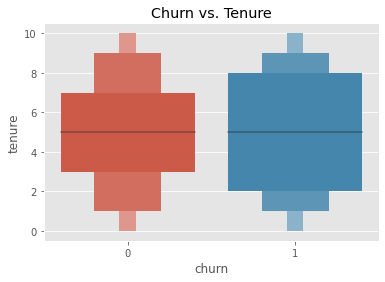

In [204]:
sns.boxenplot(df['churn'], df['tenure'])
plt.title('Churn vs. Tenure')
plt.savefig('../Images/Churn_vs_Tenure.png')

Again, similar distributions are observed.

Try salary vs. churn

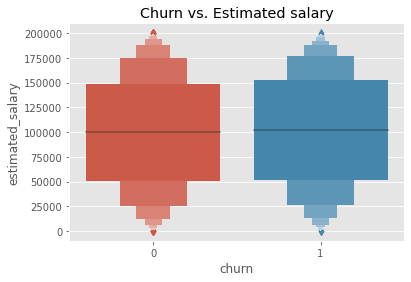

In [205]:
sns.boxenplot(df['churn'], df['estimated_salary'])
plt.title('Churn vs. Estimated salary')
plt.savefig('../Images/Churn_vs_Estimated_salary.png')

Identical distributions, no clues here!

Does churn have any correlation to age?

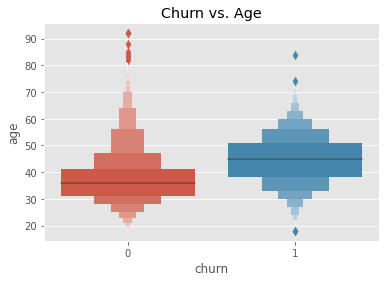

In [206]:
sns.boxenplot(df['churn'], df['age'])
plt.title('Churn vs. Age')
plt.savefig('../Images/Churn_vs_Age.png')

Churners tend to be older!

Does gender matter?

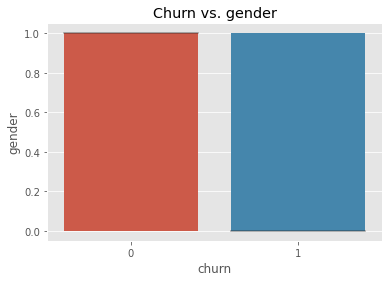

In [207]:
sns.boxenplot(df['churn'], df['gender'])
plt.title('Churn vs. gender')
plt.savefig('../Images/Churn_vs_Gender.png')

No, not at all.

Does having a credit card vs churn look interesting?

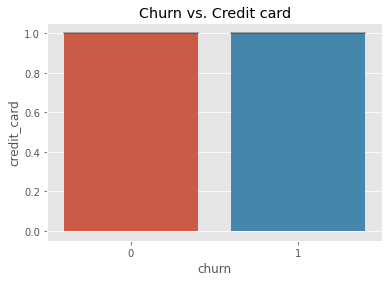

In [208]:
sns.boxenplot(df['churn'], df['credit_card'])
plt.title('Churn vs. Credit card')
plt.savefig('../Images/Churn_vs_Credit_card.png')

Nope.

How about whether the customer is active or not?

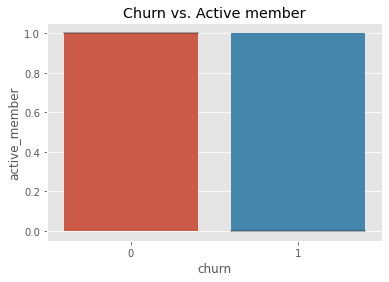

In [209]:
sns.boxenplot(df['churn'], df['active_member'])
plt.title('Churn vs. Active member')
plt.savefig('../Images/Churn_vs_Active_member.png')

Churn appears identical for both active and non-active members

Finally, let's check the distribution of number of products a customer uses against churn

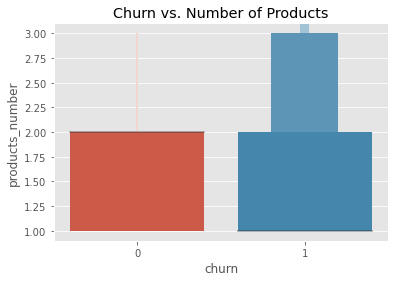

In [210]:
sns.boxenplot(df['churn'], df['products_number'])
plt.title('Churn vs. Number of Products')
plt.savefig('../Images/Churn_vs_Products_number.png')

Customers using more products churn more!

Other than 'country' and 'products_number, all the other predictors appear to have little obvious impact on churn. We shall have to let the ML models do their job!

But first, deal with the 'country' categorical feature - use get_dummies

In [211]:
# Encode the category 'country'
X = pd.get_dummies(df)

In [212]:
# Take the label out of X and into y, take out the redundant feature 'country_Spain' from X
Full_y = X['churn']
Full_X = X.drop(['country_Spain', 'churn'], axis=1)
print(f'Full X shape: {Full_X.shape}')
print(f'Full y shape: {Full_y.shape}')

Full X shape: (10000, 11)
Full y shape: (10000,)


## Model Selection: Crossvalidate various models, look for best Recall

### Split the data

In [213]:
X_train, X_final_test, y_train, y_final_test \
    = train_test_split(Full_X, Full_y, test_size=0.10, train_size=0.90, random_state=13)

In [214]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_final_test shape: {X_final_test.shape}')
print(f'y_final test shape: {y_final_test.shape}')

X_train shape: (9000, 11)
y_train shape: (9000,)
X_final_test shape: (1000, 11)
y_final test shape: (1000,)


### Compare Models: LogisticRegression, RandomForestClassifier, and GradientBoostingClassifier 

#### Helper function: run_models( )

In [215]:
def run_models(estimator_class, X_train, y_train, n_splits=5, stratified=False, sampling=None):

    if stratified:
        kf = StratifiedKFold(n_splits, shuffle=True)
    else:
        kf = KFold(n_splits, shuffle=True)
    
    accuracy = []
    precision = []
    recall = []
    for train_idx, test_idx in kf.split(X_train, y_train):

        # Setup the fold's test data
        X_test_fold = X_train.iloc[test_idx]
        y_test_fold = y_train.iloc[test_idx]

        # Now setup the fold's train data as per the kf.split
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        
        
        # Then balance the classes as per the sampling parameter
        
        if sampling == 'SMOTE':

            # oversample the fold's train data to balance the classes
            oversample = SMOTE()
            X_train_fold, y_train_fold \
                = oversample.fit_resample(X_train_fold, y_train_fold)
            
        elif sampling == 'UNDER':

            # First put X_train and y_train together
            Xy_temp = pd.concat([X_train_fold, y_train_fold], axis=1)
            # Take all samples that are in the minority class
            Xy_temp_minority = Xy_temp[Xy_temp['churn'] == 1]
            # Take an equal number of samples from the majority class
            Xy_temp_majority = Xy_temp[Xy_temp['churn'] == 0] \
                                .sample(Xy_temp_minority.shape[0])
            # then append
            Xy_temp_balanced = Xy_temp_minority.append(Xy_temp_majority)
            
            # Now pull out y_train_fold data
            y_train_fold = Xy_temp_balanced['churn']
            # and drop the label to get the X_train_fold data
            X_train_fold = Xy_temp_balanced.drop(['churn'], axis=1)

        elif sampling == 'OVER':

            # First put X_train and y_train together
            Xy_temp = pd.concat([X_train_fold, y_train_fold], axis=1)
            # Take all samples that are in the majority class
            Xy_temp_majority = Xy_temp[Xy_temp['churn'] == 0]
            # Take an equal number of samples from the minority class
            Xy_temp_minority = Xy_temp[Xy_temp['churn'] == 1] \
                                .sample(Xy_temp_majority.shape[0], replace=True)
            # then append
            Xy_temp_balanced = Xy_temp_majority.append(Xy_temp_minority)
            
            # Now pull out y_train_fold data
            y_train_fold = Xy_temp_balanced['churn']
            # and drop the label to get the X_train_fold data
            X_train_fold = Xy_temp_balanced.drop(['churn'], axis=1)

        elif sampling == 'SMOTE&UNDER':
            
            # setup
            oversample = SMOTE(sampling_strategy=0.5)
            undersample = RandomUnderSampler(sampling_strategy=1)
            # oversample majority class
            X_train_fold, y_train_fold \
                = oversample.fit_resample(X_train_fold, y_train_fold)
            # then undersample minority
            X_train_fold, y_train_fold \
                = undersample.fit_resample(X_train_fold, y_train_fold)
             
        # fit model, predict, compute scores
        estimator = estimator_class()
        estimator.fit(X_train_fold, y_train_fold)
        y_preds_fold = estimator.predict(X_test_fold)
        accuracy.append(accuracy_score(y_test_fold, y_preds_fold))
        precision.append(precision_score(y_test_fold, y_preds_fold))
        recall.append(recall_score(y_test_fold, y_preds_fold))
        
    return (accuracy, precision, recall)

#### Helper function: show_model_scores( )

In [216]:
def show_model_scores(estimators, results, n_splits=5, suffix=''):

    fig, axs = plt.subplots(1, len(results), figsize=(15, 5))

    for i, estimator in enumerate(estimators):

        axs[i].set_title(estimator.__name__ + suffix, fontsize=10)
        axs[i].plot(range(1, (n_splits+1)), results[i][0], label='Accuracy', c='green')
        axs[i].plot(range(1, (n_splits+1)), results[i][1], label='Precision', c='red')
        axs[i].plot(range(1, (n_splits+1)), results[i][2], label='Recall', c='blue')
        axs[i].set_ylabel('Accuracy, Precision, Recall', fontsize=10)
        axs[i].set_xlabel('Number of folds', fontsize=10)
        axs[i].legend()
        
        print('\n***********************************************')
        print(estimator.__name__ + suffix)
        print('***********************************************')
        print('Average Accuracy  = ', round(np.mean(results[i][0]), 2))
        print('Average Precision = ', round(np.mean(results[i][1]), 2))
        print('Average Recall    = ', round(np.mean(results[i][2]), 2))
        print('***********************************************')

    fig.savefig('../Images/ModelScores'+suffix)

#### Run the models and observe their scores

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



***********************************************
LogisticRegression (Not Stratifed)
***********************************************
Average Accuracy  =  0.79
Average Precision =  0.38
Average Recall    =  0.05
***********************************************

***********************************************
RandomForestClassifier (Not Stratifed)
***********************************************
Average Accuracy  =  0.86
Average Precision =  0.77
Average Recall    =  0.46
***********************************************

***********************************************
GradientBoostingClassifier (Not Stratifed)
***********************************************
Average Accuracy  =  0.86
Average Precision =  0.77
Average Recall    =  0.47
***********************************************


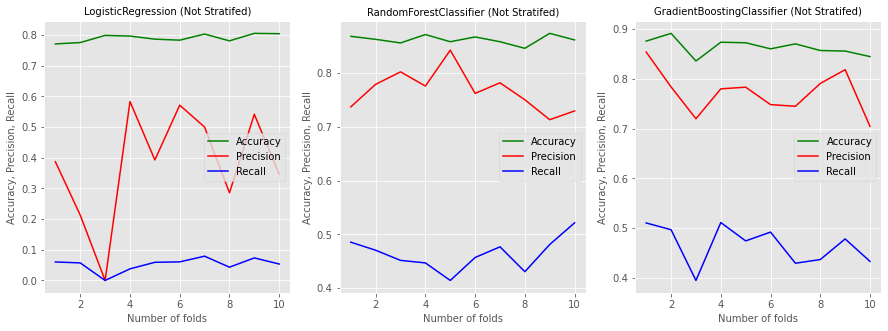

In [217]:
estimators = [LogisticRegression, RandomForestClassifier, GradientBoostingClassifier]
results = []
for estimator in estimators:
    results.append((run_models(estimator, X_train, y_train, n_splits=10)))

show_model_scores(estimators, results, n_splits=10, suffix=' (Not Stratifed)')

Accuracy, and Precision are reasonable, however, Recall is poor - *but this is the metric we're most interested in* because false negatives (not finding churners) is what we most want to minimize. Our poor Recall scores are likely because of the imbalance between our classes in the training data:

    No churn: 79.63%
    Churn:    20.37%
    
Rather than Accuracy, we should consider alternate measures, such as:

- Recall/Sensitivity: how many relevant instances are selected.

as well as:

- Precision/Specificity: how many selected instances are relevant.
- F1 score: harmonic mean of precision and recall.
- MCC: correlation coefficient between the observed and predicted binary classifications.
- AUC: relation between true-positive rate and false positive rate.

A few techniques to consider are:

- Undersampling the majority class: reducing the size of the abundant class in training data
- Oversampling the minority class: generating new rare samples using repetition, bootstrapping or SMOTE (Synthetic Minority Over-Sampling Technique)
- A combination of the above 2 methods

But first, let's observe what StratifyKFold does: preserving the class  the samples during the KFold process to preserve the proportion of both classes, so that we don't see zero values for precision because there happen to be no samples of the minority class in any particular fold

#### Run Startified KFolds (to try to avoid having folds that happen to have zero examples of the minority class


***********************************************
LogisticRegression (Stratified)
***********************************************
Average Accuracy  =  0.79
Average Precision =  0.4
Average Recall    =  0.06
***********************************************

***********************************************
RandomForestClassifier (Stratified)
***********************************************
Average Accuracy  =  0.86
Average Precision =  0.76
Average Recall    =  0.46
***********************************************

***********************************************
GradientBoostingClassifier (Stratified)
***********************************************
Average Accuracy  =  0.86
Average Precision =  0.78
Average Recall    =  0.47
***********************************************


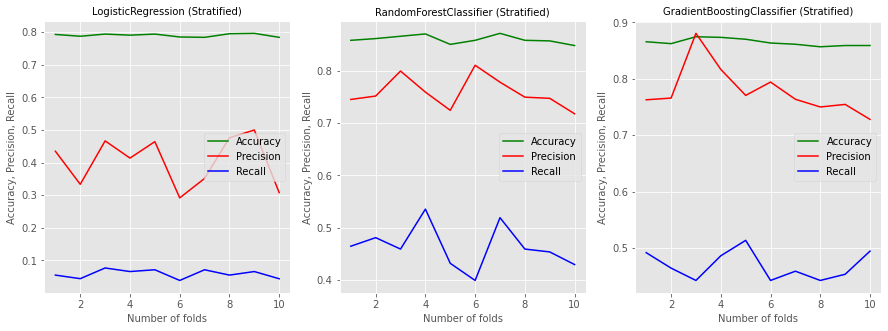

In [218]:
estimators = [LogisticRegression, RandomForestClassifier, GradientBoostingClassifier]
results = []
for estimator in estimators:
    results.append((run_models(estimator, X_train, y_train, n_splits=10, stratified=True)))
show_model_scores(estimators, results, n_splits=10, suffix=' (Stratified)')

About the Precision, no zero values (because no fold has zero samples of the minority class) - however, Recall is still poor.

### Addressing class imbalance: Under-sampling the majority class 

In [219]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

# count the minority class
print(y_train[y_train == 1].shape)

X_train shape: (9000, 11)
y_train shape: (9000,)
(1831,)



***********************************************
LogisticRegression (Undersampled)
***********************************************
Average Accuracy  =  0.64
Average Precision =  0.32
Average Recall    =  0.67
***********************************************

***********************************************
RandomForestClassifier (Undersampled)
***********************************************
Average Accuracy  =  0.78
Average Precision =  0.48
Average Recall    =  0.73
***********************************************

***********************************************
GradientBoostingClassifier (Undersampled)
***********************************************
Average Accuracy  =  0.79
Average Precision =  0.49
Average Recall    =  0.75
***********************************************


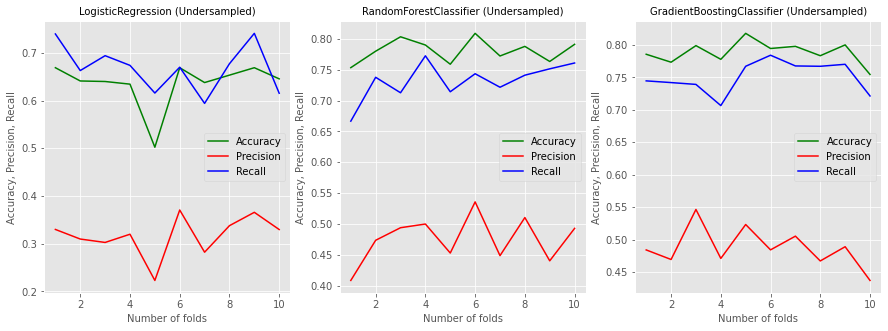

In [220]:
# Now see if the models do better with this under-sampled data
estimators = [LogisticRegression, RandomForestClassifier, GradientBoostingClassifier]
results = []
for estimator in estimators:
    results.append((run_models(estimator, X_train, y_train, n_splits=10, stratified=False, sampling='UNDER')))
show_model_scores(estimators, results, n_splits=10, suffix=' (Undersampled)')

Much better Recall!

###  Addressing class imbalance: Over-sampling the minority class


***********************************************
LogisticRegression (Oversampled-Replace)
***********************************************
Average Accuracy  =  0.62
Average Precision =  0.31
Average Recall    =  0.67
***********************************************

***********************************************
RandomForestClassifier (Oversampled-Replace)
***********************************************
Average Accuracy  =  0.85
Average Precision =  0.69
Average Recall    =  0.51
***********************************************

***********************************************
GradientBoostingClassifier (Oversampled-Replace)
***********************************************
Average Accuracy  =  0.8
Average Precision =  0.51
Average Recall    =  0.75
***********************************************


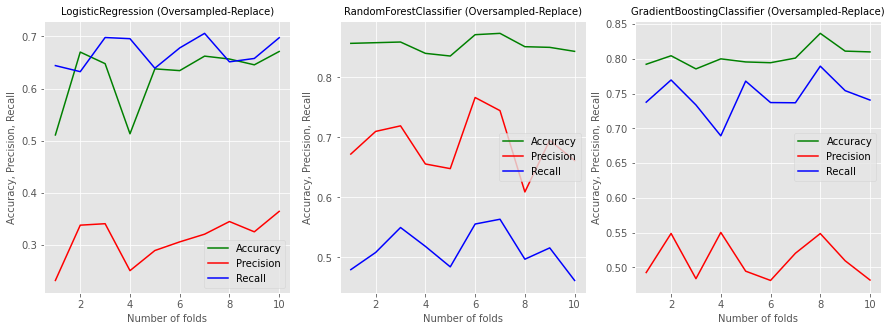

In [221]:
# Now see if the models do better with this over-sampled data
estimators = [LogisticRegression, RandomForestClassifier, GradientBoostingClassifier]
results = []
for estimator in estimators:
    results.append((run_models(estimator, X_train, y_train, n_splits=10, stratified=False, sampling='OVER')))
show_model_scores(estimators, results, n_splits=10, suffix=' (Oversampled-Replace)')

#### GradientBoostingClassifier much better on Recall

###  Addressing class imbalance: Synthetic Minority Oversampling Technique (SMOTE)

New examples synthesized from the existing examples to address class imbalance.


***********************************************
LogisticRegression (Oversampled-SMOTE)
***********************************************
Average Accuracy  =  0.62
Average Precision =  0.3
Average Recall    =  0.65
***********************************************

***********************************************
RandomForestClassifier (Oversampled-SMOTE)
***********************************************
Average Accuracy  =  0.82
Average Precision =  0.54
Average Recall    =  0.62
***********************************************

***********************************************
GradientBoostingClassifier (Oversampled-SMOTE)
***********************************************
Average Accuracy  =  0.8
Average Precision =  0.52
Average Recall    =  0.65
***********************************************


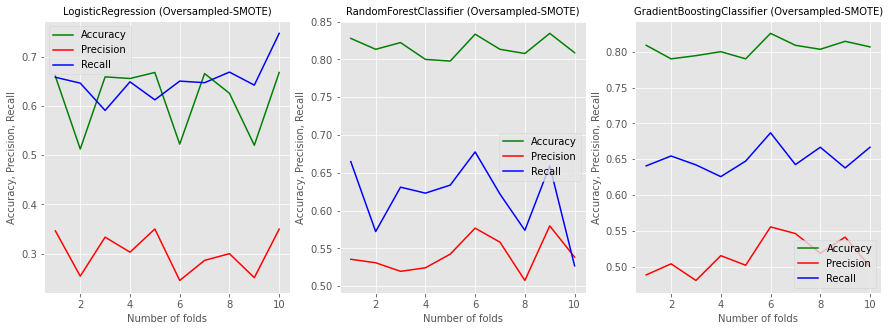

In [222]:
# Now that the classes are balanced, run the models
estimators = [LogisticRegression, RandomForestClassifier, GradientBoostingClassifier]
results = []
for estimator in estimators:
    results.append((run_models(estimator, X_train, y_train, n_splits=10,\
                               stratified=False, sampling='SMOTE')))
show_model_scores(estimators, results, n_splits=10, suffix=' (Oversampled-SMOTE)')

#### The *RandomForestClassifier with SMOTE oversampling* appears to be the best for Recall and for Accuracy and Precision, so far.

###  Addressing class imbalance: A combination of SMOTE and Random Undersampling 


***********************************************
LogisticRegression (Rebalanced-SMOTE&Under)
***********************************************
Average Accuracy  =  0.63
Average Precision =  0.31
Average Recall    =  0.65
***********************************************

***********************************************
RandomForestClassifier (Rebalanced-SMOTE&Under)
***********************************************
Average Accuracy  =  0.8
Average Precision =  0.5
Average Recall    =  0.68
***********************************************

***********************************************
GradientBoostingClassifier (Rebalanced-SMOTE&Under)
***********************************************
Average Accuracy  =  0.8
Average Precision =  0.5
Average Recall    =  0.71
***********************************************


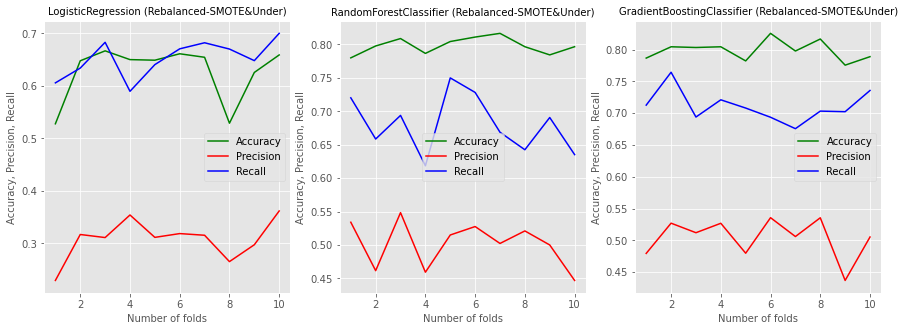

In [223]:
# Now that the classes are rebalanced, run the models
estimators = [LogisticRegression, RandomForestClassifier, GradientBoostingClassifier]
results = []
for estimator in estimators:
    results.append((run_models(estimator, X_train, y_train, n_splits=10, \
                               stratified=False, sampling='SMOTE&UNDER')))
show_model_scores(estimators, results, n_splits=10, suffix=' (Rebalanced-SMOTE&Under)')

#### The best results for Recall came from just oversampling (with replacement) the minority class

### Now run the best models on the test data (with random oversampling on the minority class) and compare the results

In [254]:
#Setup the data

# First put X_train and y_train together
Xy_temp = pd.concat([X_train, y_train], axis=1)
# Take all samples that are in the majority class
Xy_temp_majority = Xy_temp[Xy_temp['churn'] == 0]
# Take an equal number of samples from the minority class
Xy_temp_minority = Xy_temp[Xy_temp['churn'] == 1] \
                    .sample(Xy_temp_majority.shape[0], replace=True)
# then append
Xy_temp_balanced = Xy_temp_majority.append(Xy_temp_minority)
print(Xy_temp_balanced.shape)

# Now pull out y_train_fold data
y_train_balanced = Xy_temp_balanced['churn']
# and drop the label to get the X_train_fold data
X_train_balanced = Xy_temp_balanced.drop(['churn'], axis=1)# data prep

# Run the models

# RandomForestClassifier
RFC_base = RandomForestClassifier()
RFC_base.fit(X_train_balanced, y_train_balanced)
y_pred = RFC_base.predict(X_final_test)
print('\n********************************************')
print('Model: RandomForestClassifier')
print('********************************************')
print('Accuracy  = ', round(accuracy_score(y_final_test, y_pred), 2))
print('Precision = ', round(precision_score(y_final_test, y_pred), 2))
print('Recall    = ', round(recall_score(y_final_test, y_pred), 2))
print('********************************************')

# GradientBoostingClassifier
GBC_base = GradientBoostingClassifier()
GBC_base.fit(X_train_balanced, y_train_balanced)
y_pred = GBC_base.predict(X_final_test)
print('\n********************************************')
print('Model: GradientBoostingClassifier')
print('********************************************')
print('Accuracy  = ', round(accuracy_score(y_final_test, y_pred), 2))
print('Precision = ', round(precision_score(y_final_test, y_pred), 2))
print('Recall    = ', round(recall_score(y_final_test, y_pred), 2))
print('********************************************')

(14338, 12)

********************************************
Model: RandomForestClassifier
********************************************
Accuracy  =  0.86
Precision =  0.71
Recall    =  0.53
********************************************

********************************************
Model: GradientBoostingClassifier
********************************************
Accuracy  =  0.82
Precision =  0.56
Recall    =  0.75
********************************************


## Choose GradientBoostingClassifier and tune it

### Establish the base line 

********************************************
Model: GradientBoostingClassifier
********************************************
Accuracy  =  0.83
Precision =  0.56
Recall    =  0.75
********************************************

### Examine feature importances

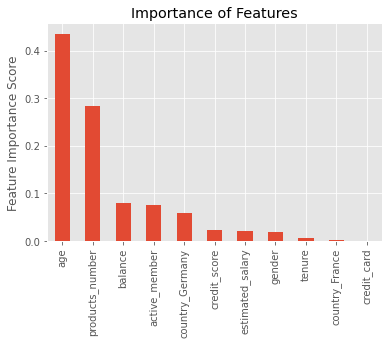

In [237]:
# plot feature importances and classification report
feat_imp = pd.Series(GBC_base.feature_importances_, X_train_balanced.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score');

#### Try with last 3 features dropped

In [255]:
# GradientBoostingClassifier
X_train_dropped_features = X_train_balanced.drop(
    ['tenure', 'country_France', 'credit_card'], axis=1)
GBC_dropped_features = GradientBoostingClassifier()
GBC_dropped_features.fit(X_train_dropped_features, y_train_balanced)
X_final_test_dropped_features = X_final_test.drop(
    ['tenure', 'country_France', 'credit_card'], axis=1)
y_pred = GBC_dropped_features.predict(X_final_test_dropped_features)
print('\n****************************************************')
print('Model: GradientBoostingClassifier - dropped features')
print('****************************************************')
print('Accuracy  = ', round(accuracy_score(y_final_test, y_pred), 2))
print('Precision = ', round(precision_score(y_final_test, y_pred), 2))
print('Recall    = ', round(recall_score(y_final_test, y_pred), 2))
print('****************************************************')


****************************************************
Model: GradientBoostingClassifier - dropped features
****************************************************
Accuracy  =  0.82
Precision =  0.56
Recall    =  0.73
****************************************************


In [ ]:
#### No advantage gained by dropping features

### Now grid search for best hyperparameters

#### Set up helper function: gridsearch_with_output( )

In [264]:
def gridsearch_with_output(estimator, parameter_grid, X_train, y_train):
    '''
        Parameters: estimator: the type of model (e.g. RandomForestRegressor())
                    paramter_grid: dictionary defining the gridsearch parameters
                    X_train: 2d numpy array
                    y_train: 1d numpy array
        Returns:  best parameters and model fit with those parameters
    '''
    model_gridsearch = GridSearchCV(estimator,
                                    parameter_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    scoring='recall')
    model_gridsearch.fit(X_train, y_train)
    best_params = model_gridsearch.best_params_ 
    model_best = model_gridsearch.best_estimator_
    print("\nResult of gridsearch:")
    print("{0:<20s} | {1:<8s} | {2}".format("Parameter", "Optimal", "Gridsearch values"))
    print("-" * 55)
    for param, vals in parameter_grid.items():
        print("{0:<20s} | {1:<8s} | {2}".format(str(param), 
                                                str(best_params[param]),
                                                str(vals)))
    return best_params, model_best

#### Set up helper function: display_default_and_gsearch_model_results(  )

In [265]:
def display_default_and_gsearch_model_results(model_default, model_best, 
                                              X_test, y_test):
    '''
        Parameters: model_default: fit model using initial parameters
                    model_best: fit model using parameters from gridsearch
                    X_test: 2d numpy array
                    y_test: 1d numpy array
        Return: None, but prints out recall the default and model with
                gridsearched parameters
    '''
    name = model_default.__class__.__name__ # for printing
    y_test_pred = model_best.predict(X_test)
    recall = recall_score(y_test, y_test_pred)
    print("Results for {0}".format(name))
    print("Gridsearched model Recall: {:0.3f}".format(recall))
    y_test_pred = model_default.predict(X_test)
    recall = recall_score(y_test, y_test_pred)
    print("     Default model Recall: {:0.3f}".format(recall))
    

#### Grid search for best model parameters on the balanced training data

#### Run the grid search

In [247]:
# Grid search 1

# model_grid = {'max_depth': [2, 3, None],
#               'max_features': ['sqrt', 'log2', None],
#               'min_samples_split': [2, 4],
#               'min_samples_leaf': [1, 2, 4],
#               'learning_rate': [0.1, 0.05, 0.25],
#               'n_estimators': [400, 800],
#               'random_state': [1]}
# best_params, best_model = gridsearch_with_output(GBC_base, 
#                                                  model_grid, 
#                                                  X_train_balanced, y_train_balanced)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   50.8s
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 54.8min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 77.8min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | None     | [2, 3, None]
max_features         | None     | ['sqrt', 'log2', None]
min_samples_split    | 2        | [2, 4]
min_samples_leaf     | 4        | [1, 2, 4]
learning_rate        | 0.1      | [0.1, 0.05, 0.25]
n_estimators         | 400      | [400, 800]
random_state         | 1        | [1]


In [266]:
model_grid = {'max_depth': [1, None],
              'max_features': [None],
              'min_samples_split': [2, 4],
              'min_samples_leaf': [1, 2, 4],
              'learning_rate': [0.1],
              'n_estimators': [400],
              'random_state': [1]}
best_params, best_model = gridsearch_with_output(GBC_base, 
                                                 model_grid, 
                                                 X_train_balanced, y_train_balanced)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.6min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | None     | [1, None]
max_features         | None     | [None]
min_samples_split    | 2        | [2, 4]
min_samples_leaf     | 2        | [1, 2, 4]
learning_rate        | 0.1      | [0.1]
n_estimators         | 400      | [400]
random_state         | 1        | [1]


In [267]:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Now try the tuned model on the final test data

### GradientBoostingClassifier(
{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### - with random oversampling of training data

In [268]:
# X_final_test.shape

# GBC_base.get_params()

In [269]:
print("\nComparing model with gridsearch params to initial model on Test set.")
best_model.fit(X_train_balanced, y_train_balanced)
display_default_and_gsearch_model_results(GBC_base, best_model, X_final_test, y_final_test)


Comparing model with gridsearch params to initial model on Test set.
Results for GradientBoostingClassifier
Gridsearched model Recall: 0.490
     Default model Recall: 0.748


### Examine a profit curve

#### Set up a plausible cost-benefit matrix

Assumptions: 
- A customer who leaves the bank will result in average annual revenue loss of $912
  (This is sourced from a study of the Annual Report of JP Morgan Chase from 2011)
  
- The typical cost of following up and incentivizing a customer to not to churn is $200
- Let us assume that the customers who are thus incentivized do not churn

### Estimated average earning per customer

According to the European Central Bank
(https://www.ecb.europa.eu/press/pr/stats/mfi/html/ecb.mir1902~e5d8025000.en.html)

- Typical retail interest rate for loans in February 2019 was 1.80%.
- Typical retail interest for deposits 0.37%.

A rough earnings per cusomer would be their average bal into the differential lending/borrowing rate 1.43%

In [281]:
# Annual average earning per customer
avg_earning = X_train['balance'].mean()*0.0143
avg_earning

1099.0808007385574

In [270]:
#                    Predicted Negative(Will not churn)     Predicted Positive(Will churn)
# 
# Actual Negative        TN $0 (status quo)                       FP -$200 
# (Did not churn)
#
#
# Actual positive         FN -$1000 (lost)                         TP  $800 (retained)
# (Did churn)


In [271]:
y_probas = best_model.predict_proba(X_final_test)
thresholds = np.linspace(0, 1, 100)

In [288]:
cost_benefit_matrix = np.array([[950, -50], 
                                [-1000, 0]])

profits = []
for thresh in thresholds:
    classes = y_probas[:, 1] > thresh
    classes = [1 if c == True else 0 for c in classes]
    
    [[tn, fp], [fn, tp]] = confusion_matrix(y_final_test, classes)
    conf_matrix = np.array([[tp, fp], [fn, tn]])
    
    profit = np.sum(conf_matrix * cost_benefit_matrix)
    profits.append(profit)

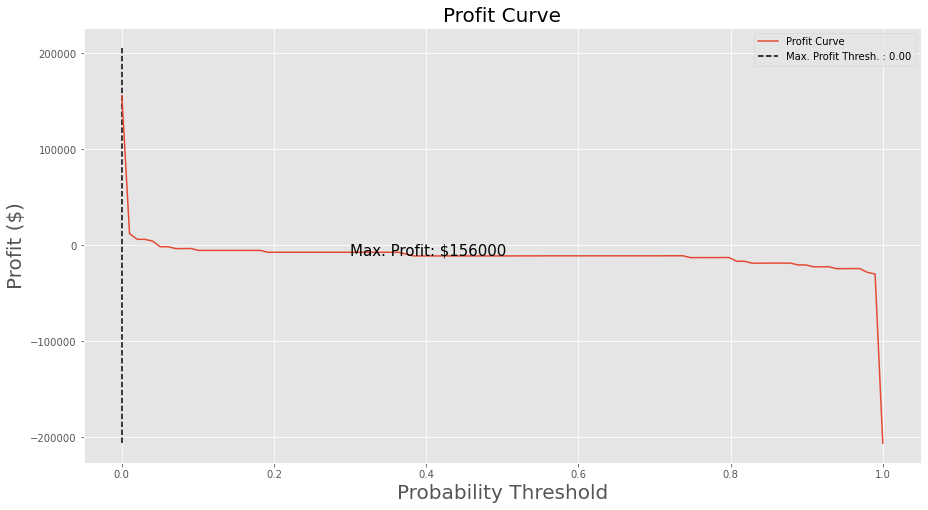

In [290]:
max_prof = np.argmax(profits)
max_thresh = thresholds[max_prof]

min_ = min(profits)
max_ = max(profits)

plt.figure(figsize=(15, 8))
plt.plot(thresholds, profits, label='Profit Curve')
plt.vlines(max_thresh, min_, max_ + 50000, linestyle='--', label='Max. Profit Thresh. : %.2f' % max_thresh)
plt.ylabel('Profit ($)', fontsize=20)
plt.xlabel('Probability Threshold', fontsize=20)
plt.title('Profit Curve', fontsize=20)
plt.text(0.3, -10000, 'Max. Profit: $%d' % max_, fontsize=15)
plt.legend(loc=1);

### Some useful unix commands
From Tony Marquez to Everyone: 

wc -l

pip install --upgrade pandas

!head filename

head -n 100 filename > testfile.json